In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bisection
from joblib import Parallel, delayed
import scipy.spatial
import huffman
import GaussianSource as GS
import torch
from rd_primal_minmax_gaussian_bisection import GenRD, GaussianDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST,MNIST, CIFAR10
from torch.utils.data import DataLoader

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

In [3]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth':1.25})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["font.family"] = "serif"

In [4]:
m = 20
r = 0.25
sigmas = 2*np.exp(-r*np.arange(m))

# m = 1024
# r = 0.025
# sigmas = 2*np.exp(-r*np.arange(m))


In [ ]:
GS.rd_gaussian(6, sigmas)*np.log(2)

In [5]:
D_max =sum(sigmas**2)
DD = np.geomspace(0.01, 1.1*D_max, 100)
RR = []
for D in DD:
    RR.append(GS.rd_gaussian(D, sigmas))
DD = np.array(DD)
RR = np.array(RR)

In [6]:
# sigmas = np.exp(-0.25*np.arange(m))
# sigmas = np.ones(m)
RR_PFR = []
DD_PFR = []
sweep = np.linspace(0.001, 1.1*D_max, 20)
N = 500000
rd_PFR = np.array(Parallel(n_jobs=-1)(delayed(GS.RD_PFR_block)(D, sigmas, N, method='PFR') for D in sweep))

RR_ORC = []
DD_ORC = []
sweep = np.linspace(0.001, 1.1*D_max, 20)
N = 500000
rd_ORC = np.array(Parallel(n_jobs=-1)(delayed(GS.RD_PFR_block)(D, sigmas, N, method='ORC') for D in sweep))

10.5936 finished
11.1821 finished
9.4166 finished
8.8282 finished
10.0051 finished
7.6512 finished
8.2397 finished
7.0627 finished
5.2973 finished
6.4742 finished
5.8858 finished
4.1203 finished
4.7088 finished
2.9434 finished
3.5319 finished
1.7664 finished
2.3549 finished
1.1780 finished
0.5895 finished
0.0010 finished
10.5936 finished
11.1821 finished
8.8282 finished
10.0051 finished
9.4166 finished
7.6512 finished
8.2397 finished
7.0627 finished
6.4742 finished
5.8858 finished
5.2973 finished
4.7088 finished
4.1203 finished
3.5319 finished
2.9434 finished
2.3549 finished
1.7664 finished
1.1780 finished
0.5895 finished
0.0010 finished


In [18]:
# r = 0.25
RR_DNN = np.array([ 2, 4.     ,  6.     ,  8.     , 12.     , 14.33985, 18.     ])
dists_DNN = np.array([6.80288408, 4.62322701, 4.03686346, 2.43354822, 1.75967654,
       1.58059808, 0.93856596])

#r = 0.05
# RR_DNN = np.array([30.,  20.,  24.,  16.,   12.,  8.])
# dists_DNN = np.array([11.22884653,  12.90090699,  14.39782373,
#         15.90634339,   22.7901304 ,
#        23.980158  ])

In [10]:
#NERD
trainset = GaussianDataset(n_samples=30000, m=m, r=r)
loader = torch.utils.data.DataLoader(trainset, batch_size=30000,
                                              shuffle=True, num_workers=2, pin_memory=True)

DD_ = [9,8,7,6,5,4,3,2,1.5,1]
# DD_ = [70, 60, 50, 40, 30, 20, 15, 10]
# DD_.reverse()
# DD_ = np.array(DD_)*10
rates_true_rd = []
dists_true_rd = []
for D in DD_:
    # eps = 1e-10 if D in [1, 1.5] else 1e-20
    eps = 1e-14
    model = GenRD(latent_dim=m, D=D, eps=eps)
    checkpoint = torch.load(f'trained_gaussian/trained_genRD_minmax_gaussian/GenRD_trained_genRD_minmax_gaussian_D{D:.3f}.pt')
    model.load_state_dict(checkpoint)
    model.to(device)
    # eps = 1e-20 if D == 1 else 1e-20
    r, d, beta = calc_RD(loader, model, D, eps=1e-30) 
    print(f'r={r:.4f}, d_alt={d:.4f}, d={D:.4f}, beta={beta:.4f}')
    rates_true_rd.append(r)
    dists_true_rd.append(d)

r=0.2422, d_alt=9.0000, d=9.0000, beta=-0.1691
r=0.5390, d_alt=8.0000, d=8.0000, beta=-0.2296
r=0.9230, d_alt=7.0000, d=7.0000, beta=-0.3018
r=1.4345, d_alt=6.0000, d=6.0000, beta=-0.4009
r=2.1092, d_alt=5.0000, d=5.0000, beta=-0.5448
r=3.0432, d_alt=4.0000, d=4.0000, beta=-0.7595
r=4.4105, d_alt=3.0000, d=3.0000, beta=-1.1550
r=6.6652, d_alt=2.0000, d=2.0000, beta=-2.0425
r=8.5403, d_alt=1.5031, d=1.5000, beta=-3.4203
r=13.1134, d_alt=1.1028, d=1.0000, beta=-8.9471


In [81]:
5.1/np.log(2)

7.357744708533713

In [11]:
from scipy.stats import ortho_group
np.random.seed(seed=233423)
U = ortho_group.rvs(m)

In [95]:
GS.rd_gaussian(70, sigmas)

3.269301444873266

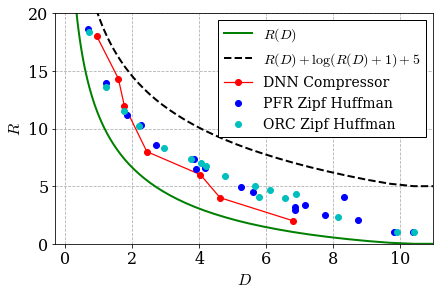

In [31]:
plt.figure(1, constrained_layout=True)
plt.plot(DD, RR, '-', color='g', linewidth=2, label=r'$R(D)$')
# plt.plot(DD_, rates_true_rd, 'o', color='k', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none')
plt.plot(DD, RR+np.log2(RR+1)+5, '--', color='k', linewidth=2, label=r'$R(D)+\log(R(D)+1)+5$')
plt.plot(dists_DNN, RR_DNN, '-o', color='r', label='DNN Compressor')
plt.plot(rd_PFR[:,1], rd_PFR[:,0], 'o', color='b', label='PFR Zipf Huffman')
plt.plot(rd_ORC[:,1], rd_ORC[:,0], 'o', color='c', label='ORC Zipf Huffman')
# plt.plot()
# plt.axvline(sum(sigmas**2),  **{'linestyle':'--', 'color': 'm'}, linewidth=2)
plt.xlabel('$D$')
plt.ylabel('$R$')
plt.grid(linestyle='dashed')
plt.legend(fontsize=14)
plt.xlim([-0.3, 11])
plt.ylim([0, 20])
# plt.plot(DD, R)
# plt.savefig('plots/gaussian_NERD2.pdf')
plt.savefig('plots/gaussian_m20_r.25.pdf')

In [7]:
def calc_RD(loader, model, D, eps=1e-14):
    Rate = 0
    Dist = 0
    model.to(device)
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            z = torch.randn(x.shape[0], model.latent_dim).to(device)
            y = model.generator(z).to(device)
#             print(x.device, y.device)
            dist_mat = model._squared_distances(x,y)
            # print('hello')
            beta = model.inner_max(dist_mat)
            # print('hello2')
            # print(beta)
            # eps = 1e-20#1e-14 # 1e-10 for FMNIST, 1e-14 for MNIST
            C = torch.exp(beta*dist_mat)
            mean_z = torch.mean(C, dim=1)
            # I = (mean_z > eps)
            R = beta*D - torch.mean(torch.log(mean_z+eps))
            # D = torch.mean(C*torch.exp(beta*C) / (torch.mean(torch.exp(beta*C), dim=1)[:,None])+1e-14)
            # D = torch.mean(C*torch.exp(beta*C) / ((mean_z+eps)[:,None]))
            
            # denom_x = torch.mean(torch.exp(beta*dist_mat), dim=1) + eps
            # f_xy = dist_mat*torch.exp(beta*dist_mat) / denom_x[:,None]
            # D = torch.mean(f_xy)
            
            denom_x = torch.mean(torch.exp(beta*dist_mat), dim=1) 
            log_f_xy = torch.log(dist_mat)+beta*dist_mat-torch.log(denom_x[:,None] + eps)
            D = torch.mean(torch.exp(log_f_xy))
        
            Rate += R.item()
            Dist += D.item()
    return (Rate/np.log(2))/len(loader), Dist/len(loader), beta

def calc_RD2(loader, model, D, eps=1e-14):
    Rate = 0
    Dist = 0
    model.to(device)
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            z = torch.randn(x.shape[0], model.latent_dim).to(device)
            y = model.generator(z).to(device)
#             print(x.device, y.device)
            dist_mat = model._squared_distances(x,y)
            beta = model.inner_max(dist_mat)
            # print(beta)
            # eps = 1e-20#1e-14 # 1e-10 for FMNIST, 1e-14 for MNIST
            C = torch.exp(beta*dist_mat)
            mean_z = torch.mean(C, dim=1)
            # I = (mean_z > eps)
            mean_z[mean_z < eps] = eps
            R = beta*D - torch.mean(torch.log(mean_z))
            # D = torch.mean(C*torch.exp(beta*C) / (torch.mean(torch.exp(beta*C), dim=1)[:,None])+1e-14)
            # D = torch.mean(C*torch.exp(beta*C) / ((mean_z+eps)[:,None]))
            
            denom_x = torch.mean(torch.exp(beta*dist_mat), dim=1) 
            denom_x[denom_x < eps] = eps
            f_xy = dist_mat*torch.exp(beta*dist_mat) / denom_x[:,None]
            D = torch.mean(f_xy)
            
            Rate += R.item()
            Dist += D.item()
    return (Rate/np.log(2))/len(loader), Dist/len(loader), beta

In [98]:
sweep = np.linspace(0.7, 1.3, 50)
RR = []
DD = []
for lam in sweep:
    ent, dist, _, _ = GS.lloyd_max_ent(5, 0.5, lam)
    RR.append(ent)
    DD.append(dist)

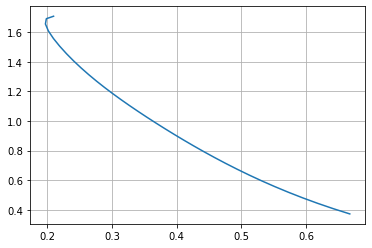

In [104]:
plt.plot(DD, RR)
plt.grid()